# 训练更好的模型

In [1]:
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [1]:
%matplotlib inline
import imp
import utils
imp.reload(utils)
from utils import *

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#path = "data/dogscats/sample/"
path = "data/dogscats/"
model_path = path + 'models/'
if not os.path.exists(model_path): 
    os.mkdir(model_path)

batch_size=16

## 模型欠拟合了吗?

Our validation accuracy so far has generally been higher than our training accuracy. That leads to two obvious questions:

1. How is this possible?
2. Is this desirable?

The answer to (1) is that this is happening because of *dropout*. Dropout refers to a layer that randomly deletes (i.e. sets to zero) each activation in the previous layer with probability *p* (generally 0.5). This only happens during training, not when calculating the accuracy on the validation set, which is why the validation set can show higher accuracy than the training set.

The purpose of dropout is to avoid overfitting. By deleting parts of the neural network at random during training, it ensures that no one part of the network can overfit to one part of the training set. The creation of dropout was one of the key developments in deep learning, and has allowed us to create rich models without overfitting. However, it can also result in underfitting if overused, and this is something we should be careful of with our model.

So the answer to (2) is: this is probably not desirable. It is likely that we can get better validation set results with less (or no) dropout, if we're seeing that validation accuracy is higher than training accuracy - a strong sign of underfitting. So let's try removing dropout entirely, and see what happens!

(We had dropout in this model already because the VGG authors found it necessary for the imagenet competition. But that doesn't mean it's necessary for dogs v cats, so we will do our own analysis of regularization approaches from scratch.)

## 移除 Dropout

Our high level approach here will be to start with our fine-tuned cats vs dogs model (with dropout), then fine-tune all the dense layers, after removing dropout from them. The steps we will take are:
- Re-create and load our modified VGG model with binary dependent (i.e. dogs v cats)
- Split the model between the convolutional (*conv*) layers and the dense layers
- Pre-calculate the output of the conv layers, so that we don't have to redundently re-calculate them on every epoch
- Create a new model with just the dense layers, and dropout p set to zero
- Train this new model using the output of the conv layers as training data.

As before we need to start with a working model, so let's bring in our working VGG 16 model and change it to predict our binary dependent...

In [3]:
model = vgg_ft(2)

...and load our fine-tuned weights.

In [4]:
model.load_weights(model_path+'finetune3.h5')

We're going to be training a number of iterations without dropout, so it would be best for us to pre-calculate the input to the fully connected layers - i.e. the *Flatten()* layer. We'll start by finding this layer in our model, and creating a new model that contains just the layers up to and including this layer:

找到最后一个卷积层

In [5]:
model.layers

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

In [6]:
layers = model.layers

In [8]:
 for index,layer in enumerate(layers):
        if type(layer) is Conv2D:
            print("1")

1
1
1
1
1
1
1
1
1
1
1
1
1


In [9]:
[index for index,layer in enumerate(layers) if type(layer) is Conv2D]

[2, 4, 7, 9, 12, 14, 16, 19, 21, 23, 26, 28, 30]

In [7]:
# 找到最后一个卷积层
last_conv_idx = [index for index,layer in enumerate(layers) if type(layer) is Conv2D][-1]

In [11]:
last_conv_idx

30

In [12]:
layers[last_conv_idx]

In [13]:
layers[:last_conv_idx+1]

In [14]:
layers[last_conv_idx+1:]

In [8]:
conv_layers = layers[:last_conv_idx+1] # 所有卷积层
conv_model = Sequential(conv_layers) # 建立顺序模型-卷积部分
# Dense layers - also known as fully connected or 'FC' layers
fc_layers = layers[last_conv_idx+1:] # 全联接层

Now we can use the exact same approach to creating features as we used when we created the linear model from the imagenet predictions in the last lesson - it's only the model that has changed. As you're seeing, there's a fairly small number of "recipes" that can get us a long way!

In [16]:
path

'data/dogscats/'

In [27]:
batches = get_batches(path+'train', shuffle=False, batch_size=batch_size)
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)

val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [18]:
val_classes

array([0, 0, 0, ..., 1, 1, 1])

In [19]:
trn_classes

array([0, 0, 0, ..., 1, 1, 1])

In [20]:
batches.class_indices

{'cats': 0, 'dogs': 1}

In [25]:
# 调用卷积层的predict_generator，提取验证集的特征
#val_features = conv_model.predict_generator(val_batches,steps=val_batches.n // batch_size) #会导致最后数量少了
val_features = conv_model.predict_generator(val_batches)
save_array(model_path + 'valid_convlayer_features.bc', val_features)

In [26]:
# 调用卷积层的predict_generator，提取训练集的特征，gpu太烂玩不了,换了1080ti能跑了！
trn_features = conv_model.predict_generator(batches,verbose=1)
save_array(model_path + 'train_convlayer_features.bc', trn_features)

360/360 [==============================] - 65s 179ms/step


In [23]:
val_features = load_array(model_path+'valid_convlayer_features.bc')
trn_features = load_array(model_path+'train_convlayer_features.bc')

In [27]:
print(trn_features.shape)
print(val_features.shape)

(23000, 512, 14, 14)
(2000, 512, 14, 14)


For our new fully connected model, we'll create it using the exact same architecture as the last layers of VGG 16, so that we can conveniently copy pre-trained weights over from that model. However, we'll set the dropout layer's p values to zero, so as to effectively remove dropout.

对于我们新的完全连接的模型，我们将使用与VGG 16的最后一层完全相同的架构来创建它，以便我们可以方便地从该模型中复制经过预先训练的权重。但是，我们会将dropout层的p值设为0，以便有效地去除dropout。

In [28]:
# Copy the weights from the pre-trained model.
# 因为移除的dropout 所以把各层权重减低为一半
def proc_wgts(layer): 
    return [o/2 for o in layer.get_weights()]

In [29]:
# 像这样非常细微的调整，学习率要设定的非常小
opt = RMSprop(lr=0.00001, rho=0.7)

In [30]:
fc_layers

In [31]:
def get_fc_model():
    model = Sequential([
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.),# 0就是删除了
        Dense(4096, activation='relu'),
        Dropout(0.),# 0就是删除了
        Dense(2, activation='softmax')
        ])

    for l1,l2 in zip(model.layers, fc_layers):
        l1.set_weights(proc_wgts(l2)) # 把预训练好的模型的权重直接赋予给新的模型，

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [32]:
fc_model = get_fc_model()

And fit the model in the usual way:

In [34]:
trn_labels.shape

(23000, 2)

In [35]:
fc_model.fit(trn_features, trn_labels, epochs=8, 
             batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/8
23000/23000 [==============================] - 29s 1ms/step - loss: 1.0587 - acc: 0.9185 - val_loss: 0.9304 - val_acc: 0.9280
Epoch 2/8
23000/23000 [==============================] - 25s 1ms/step - loss: 0.5905 - acc: 0.9500 - val_loss: 0.4804 - val_acc: 0.9460
Epoch 3/8
23000/23000 [==============================] - 26s 1ms/step - loss: 0.2254 - acc: 0.9651 - val_loss: 0.1988 - val_acc: 0.9595
Epoch 4/8
23000/23000 [==============================] - 25s 1ms/step - loss: 0.0740 - acc: 0.9916 - val_loss: 0.3443 - val_acc: 0.9560
Epoch 5/8
23000/23000 [==============================] - 24s 1ms/step - loss: 0.0460 - acc: 0.9966 - val_loss: 0.3697 - val_acc: 0.9595
Epoch 6/8
23000/23000 [==============================] - 24s 1ms/step - loss: 0.0421 - acc: 0.9972 - val_loss: 0.5136 - val_acc: 0.9550
Epoch 7/8
23000/23000 [==============================] - 24s 1ms/step - loss: 0.0411 - acc: 0.9973 - val_loss: 0.3895 - val_acc: 0.9630

In [36]:
fc_model.save_weights(model_path+'no_dropout.h5')

In [ ]:
fc_model.load_weights(model_path+'no_dropout.h5')

# 降低过拟合

我们已经让模型过拟合了，现在采取措施减少过拟合

## 降低过拟合的途径

We do not necessarily need to rely on dropout or other regularization approaches to reduce overfitting. There are other techniques we should try first, since regularlization, by definition, biases our model towards simplicity - which we only want to do if we know that's necessary. This is the order that we recommend using for reducing overfitting (more details about each in a moment):

1. Add more data
2. Use data augmentation
3. Use architectures that generalize well
4. Add regularization
5. Reduce architecture complexity.

We'll assume that you've already collected as much data as you can, so step (1) isn't relevant (this is true for most Kaggle competitions, for instance). So the next step (2) is data augmentation. This refers to creating additional synthetic data, based on reasonable modifications of your input data. For images, this is likely to involve one or more of: flipping, rotation, zooming, cropping, panning, minor color changes.

Which types of augmentation are appropriate depends on your data. For regular photos, for instance, you'll want to use horizontal flipping, but not vertical flipping (since an upside down car is much less common than a car the right way up, for instance!)

We recommend *always* using at least some light data augmentation, unless you have so much data that your model will never see the same input twice.

## 关于数据增强

Keras comes with very convenient features for automating data augmentation. You simply define what types and maximum amounts of augmentation you want, and keras ensures that every item of every batch randomly is changed according to these settings. Here's how to define a generator that includes data augmentation:

In [37]:
# dim_ordering='tf' uses tensorflow dimension ordering,
#   which is the same order as matplotlib uses for display.
# Therefore when just using for display purposes, this is more convenient
gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
       channel_shift_range=10., horizontal_flip=True)

Let's take a look at how this generator changes a single image (the details of this code don't matter much, but feel free to read the comments and keras docs to understand the details if you're interested).

In [39]:
test = ndimage.imread('data/dogscats/test1/unknown/7.jpg')

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """Entry point for launching an IPython kernel.


In [40]:
test.shape

(148, 192, 3)

In [41]:
np.expand_dims(test,0).shape

(1, 148, 192, 3)

In [42]:
# 建立“batch”的单个图片
img = np.expand_dims(ndimage.imread('data/dogscats/test1/unknown/7.jpg'),0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


In [43]:
aug_iter = gen.flow(img)

C:\Anaconda3\lib\site-packages\keras\preprocessing\image.py:1144: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_first" (channels on axis 1), i.e. expected either 1, 3 or 4 channels on axis 1. However, it was passed an array with shape (1, 148, 192, 3) (148 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


In [44]:
type(aug_iter)

keras.preprocessing.image.NumpyArrayIterator

In [45]:
aug_iter # 迭代

In [46]:
next(aug_iter)[0].astype(np.uint8) # 获得单个生成图片

array([[[149, 149, 149],
        [149, 149, 150],
        [147, 148, 148],
        ...,
        [156, 156, 156],
        [158, 157, 157],
        [157, 157, 157]],

       [[147, 147, 146],
        [147, 147, 147],
        [144, 145, 145],
        ...,
        [147, 147, 147],
        [147, 147, 147],
        [146, 147, 147]],

       [[159, 159, 158],
        [159, 159, 159],
        [156, 157, 157],
        ...,
        [163, 163, 163],
        [162, 162, 163],
        [160, 160, 161]],

       ...,

       [[252, 249, 246],
        [241, 245, 248],
        [247, 243, 240],
        ...,
        [225, 227, 229],
        [218, 219, 220],
        [225, 222, 220]],

       [[242, 242, 243],
        [240, 240, 241],
        [247, 245, 243],
        ...,
        [226, 227, 227],
        [218, 220, 222],
        [220, 218, 216]],

       [[235, 238, 241],
        [243, 240, 237],
        [250, 250, 250],
        ...,
        [235, 234, 232],
        [224, 227, 231],
        [221, 220, 218]]

In [47]:
# 获得8个生成的增强图片
aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]

In [48]:
len(aug_imgs)

8

In [49]:
img.shape

(1, 148, 192, 3)

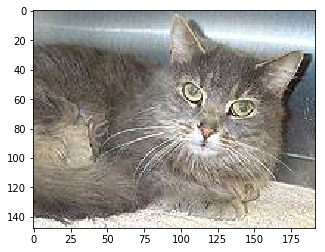

In [50]:
# 画出原始图片
plt.imshow(img[0])

As you can see below, there's no magic to data augmentation - it's a very intuitive approach to generating richer input data. Generally speaking, your intuition should be a good guide to appropriate data augmentation, although it's a good idea to test your intuition by checking the results of different augmentation approaches.

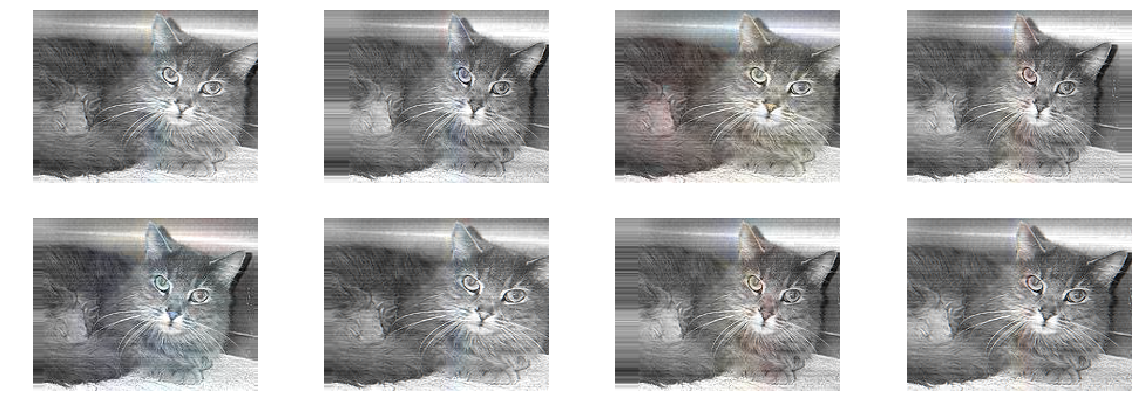

In [51]:
# 打出所有图
plots(aug_imgs, (20,7), 2)

In [52]:
# Ensure that we return to theano dimension ordering
K.set_image_dim_ordering('th')

## 增加数据增强

Let's try adding a small amount of data augmentation, and see if we reduce overfitting as a result. The approach will be identical to the method we used to finetune the dense layers in lesson 2, except that we will use a generator with augmentation configured. Here's how we set up the generator, and create batches from it:

In [53]:
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

In [54]:
batches = get_batches(path+'train', gen, batch_size=batch_size)
# NB: We don't want to augment or shuffle the validation set
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


When using data augmentation, we can't pre-compute our convolutional layer features, since randomized changes are being made to every input image. That is, even if the training process sees the same image multiple times, each time it will have undergone different data augmentation, so the results of the convolutional layers will be different.

Therefore, in order to allow data to flow through all the conv layers and our new dense layers, we attach our fully connected model to the convolutional model--after ensuring that the convolutional layers are not trainable:

当使用数据增强时，我们不能预先计算卷积层的特征，因为每个输入图像都进行了随机变化。也就是说，即使训练过程多次看到相同的图像，每次都会进行不同的数据增强，卷积层的结果也会不同。

因此，为了让数据流过所有的conv层和我们新的全联接层，我们将完全连接的模型附加到卷积模型中——在确保卷积层不可训练之后:

In [55]:
fc_model = get_fc_model()

In [56]:
for layer in conv_model.layers:
    layer.trainable = False
# 卷积层+新的全联接层，卷积层不训练
conv_model.add(fc_model)

Now we can compile, train, and save our model as usual - note that we use *fit_generator()* since we want to pull random images from the directories on every batch.

In [57]:
conv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
conv_model.fit_generator(batches,batches.n // batch_size,epochs=8,
                         validation_data=val_batches,validation_steps=val_batches.n//batch_size)

Epoch 1/8
359/359 [==============================] - 280s 781ms/step - loss: 1.1682 - acc: 0.9076 - val_loss: 0.6428 - val_acc: 0.9430
Epoch 2/8
359/359 [==============================] - 274s 763ms/step - loss: 0.3689 - acc: 0.9334 - val_loss: 0.1969 - val_acc: 0.9577
Epoch 3/8
359/359 [==============================] - 273s 761ms/step - loss: 0.1844 - acc: 0.9536 - val_loss: 0.2449 - val_acc: 0.9546
Epoch 4/8
359/359 [==============================] - 273s 760ms/step - loss: 0.1545 - acc: 0.9637 - val_loss: 0.2503 - val_acc: 0.9561
Epoch 5/8
359/359 [==============================] - 272s 759ms/step - loss: 0.1290 - acc: 0.9695 - val_loss: 0.3242 - val_acc: 0.9592
Epoch 6/8
359/359 [==============================] - 270s 751ms/step - loss: 0.1278 - acc: 0.9727 - val_loss: 0.3174 - val_acc: 0.9567
Epoch 7/8
359/359 [==============================] - 269s 749ms/step - loss: 0.1236 - acc: 0.9751 - val_loss: 0.3287 - val_acc: 0.9556
Epoch 8/8
359/359 [==============================] - 26

In [59]:
conv_model.save_weights(model_path + 'aug1.h5')

In [ ]:
conv_model.load_weights(model_path + 'aug1.h5')

## 批量标准化Batch normalization

### 关于批量标准化

Batch normalization (*batchnorm*) is a way to ensure that activations don't become too high or too low at any point in the model. Adjusting activations so they are of similar scales is called *normalization*. Normalization is very helpful for fast training - if some activations are very high, they will saturate the model and create very large gradients, causing training to fail; if very low, they will cause training to proceed very slowly. Furthermore, large or small activations in one layer will tend to result in even larger or smaller activations in later layers, since the activations get multiplied repeatedly across the layers.

Prior to the development of batchnorm in 2015, only the inputs to a model could be effectively normalized - by simply subtracting their mean and dividing by their standard deviation. However, weights in intermediate layers could easily become poorly scaled, due to problems in weight initialization, or a high learning rate combined with random fluctuations in weights.

Batchnorm resolves this problem by normalizing each intermediate layer as well. The details of how it works are not terribly important (although I will outline them in a moment) - the important takeaway is that **all modern networks should use batchnorm, or something equivalent**. There are two reasons for this:
1. Adding batchnorm to a model can result in **10x or more improvements in training speed**
2. Because normalization greatly reduces the ability of a small number of outlying inputs to over-influence the training, it also tends to **reduce overfitting**.

As promised, here's a brief outline of how batchnorm works. As a first step, it normalizes intermediate layers in the same way as input layers can be normalized. But this on its own would not be enough, since the model would then just push the weights up or down indefinitely to try to undo this normalization. Therefore, batchnorm takes two additional steps:
1. Add two more trainable parameters to each layer - one to multiply all activations to set an arbitrary standard deviation, and one to add to all activations to set an arbitary mean
2. Incorporate both the normalization, and the learnt multiply/add parameters, into the gradient calculations during backprop.

This ensures that the weights don't tend to push very high or very low (since the normalization is included in the gradient calculations, so the updates are aware of the normalization). But it also ensures that if a layer does need to change the overall mean or standard deviation in order to match the output scale, it can do so.

### 为模型添加批量标准化层

We can use nearly the same approach as before - but this time we'll add batchnorm layers (and dropout layers):

In [9]:
conv_layers[-1].output_shape[1:]

(512, 14, 14)

In [10]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096,activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(4096,activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(1000,activation='softmax')       
    ]

In [11]:
def load_fc_weights_from_vgg16bn(model):
    "Load weights for model from the dense layers of the Vgg16BN model."
    # See imagenet_batchnorm.ipynb for info on how the weights for
    # Vgg16BN can be generated from the standard Vgg16 weights.
    from myvgg16bn import Vgg16BN
    vgg16_bn = Vgg16BN()
    _, fc_layers = split_at(vgg16_bn.model, Convolution2D)
    copy_weights(fc_layers, model.layers)

In [67]:
p=0.6

In [13]:
bn_model = Sequential(get_bn_layers(0.6))

In [15]:
load_fc_weights_from_vgg16bn(bn_model)

In [16]:
def proc_wgts(layer, prev_p, new_p):
    scal = (1-prev_p)/(1-new_p)
    return [o*scal for o in layer.get_weights()]

In [17]:
for l in bn_model.layers: 
    if type(l)==Dense:
        l.set_weights(proc_wgts(l, 0.5, 0.6))

In [18]:
bn_model.pop()
for layer in bn_model.layers: 
    layer.trainable=False

In [19]:
bn_model.add(Dense(2,activation='softmax'))

In [20]:
bn_model.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

In [75]:
bn_model.fit(trn_features, trn_labels, epochs=8, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/8
23000/23000 [==============================] - 25s 1ms/step - loss: 0.8281 - acc: 0.8437 - val_loss: 0.4807 - val_acc: 0.9185
Epoch 2/8
23000/23000 [==============================] - 12s 529us/step - loss: 0.8021 - acc: 0.8564 - val_loss: 0.7957 - val_acc: 0.8865
Epoch 3/8
23000/23000 [==============================] - 11s 487us/step - loss: 0.8403 - acc: 0.8609 - val_loss: 0.5972 - val_acc: 0.9145
Epoch 4/8
23000/23000 [==============================] - 11s 484us/step - loss: 0.8636 - acc: 0.8634 - val_loss: 0.6825 - val_acc: 0.9080
Epoch 5/8
23000/23000 [==============================] - 11s 488us/step - loss: 0.8874 - acc: 0.8636 - val_loss: 0.9737 - val_acc: 0.8755
Epoch 6/8
23000/23000 [==============================] - 11s 483us/step - loss: 0.9204 - acc: 0.8645 - val_loss: 0.7229 - val_acc: 0.9090
Epoch 7/8
23000/23000 [==============================] - 11s 487us/step - loss: 0.8918 - acc: 0.8689 - val_loss: 0.6480 - val

In [76]:
bn_model.save_weights(model_path+'bn.h5')

In [21]:
bn_model.load_weights(model_path+'bn.h5')

In [22]:
bn_layers = get_bn_layers(0.6)
bn_layers.pop()
bn_layers.append(Dense(2,activation='softmax'))

In [23]:
final_model = Sequential(conv_layers)
for layer in final_model.layers: 
    layer.trainable = False
for layer in bn_layers: 
    final_model.add(layer)

In [24]:
for l1,l2 in zip(bn_model.layers, bn_layers):
    l2.set_weights(l1.get_weights())

In [25]:
final_model.compile(optimizer=Adam(), 
                    loss='categorical_crossentropy', metrics=['accuracy'])

In [90]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

In [28]:
final_model.fit_generator(batches,steps_per_epoch=batches.n // batch_size,epochs=1, validation_data=val_batches,
                 validation_steps = val_batches.n // batch_size)

Epoch 1/1
1437/1437 [==============================] - 163s 114ms/step - loss: 6.1551 - acc: 0.5731 - val_loss: 5.2557 - val_acc: 0.5010


In [ ]:
final_model.save_weights(model_path + 'final1.h5')

In [ ]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=4, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [ ]:
final_model.save_weights(model_path + 'final2.h5')

In [ ]:
final_model.optimizer.lr=0.001

In [ ]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=4, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [ ]:
bn_model.save_weights(model_path + 'final3.h5')